In [1]:
import pandas as pd
import numpy as np

# Load and pivot combined picnic data
df = pd.read_csv("data/combined_picnic_data.csv")
pivot = df.pivot(index="timestamp", columns="product", values="mid_price").dropna(subset=["CROISSANTS", "JAMS"])

# Compute ratio and z-score
pivot["ratio"] = pivot["CROISSANTS"] / pivot["JAMS"]
mean_ratio = pivot["ratio"].mean()
std_ratio = pivot["ratio"].std()
pivot["z_score"] = (pivot["ratio"] - mean_ratio) / std_ratio

# Strategy simulation function
def simulate_strategy(pivot, buy_threshold, sell_threshold, exit_threshold, order_size):
    position1 = 0
    position2 = 0
    cash = 0
    pnl_series = []

    for _, row in pivot.iterrows():
        z = row["z_score"]
        p1 = row["CROISSANTS"]
        p2 = row["JAMS"]

        # Entry logic
        if position1 == 0 and position2 == 0:
            if z > sell_threshold:
                position1 = -order_size
                position2 = order_size
                cash += order_size * p1 - order_size * p2
            elif z < -buy_threshold:
                position1 = order_size
                position2 = -order_size
                cash -= order_size * p1 - order_size * p2

        # Exit logic
        elif abs(z) < exit_threshold:
            cash += position1 * p1 + position2 * p2
            position1 = 0
            position2 = 0

        pnl = cash + position1 * p1 + position2 * p2
        pnl_series.append(pnl)

    final_pnl = pnl_series[-1]
    returns = np.diff(pnl_series)

    if len(returns) > 1 and np.std(returns) > 1e-6:
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)
    else:
        sharpe = 0

    return final_pnl, sharpe

# Grid search
buy_thresholds = np.linspace(0.4, 1.5, 12)
sell_thresholds = np.linspace(0.4, 1.5, 12)
exit_thresholds = np.linspace(0.05, 0.4, 8)
order_size = 20
results = []

for buy_z in buy_thresholds:
    for sell_z in sell_thresholds:
        for exit_z in exit_thresholds:
            if sell_z <= buy_z:
                continue
            pnl, sharpe = simulate_strategy(pivot, buy_z, sell_z, exit_z, order_size)
            results.append((buy_z, sell_z, exit_z, pnl, sharpe))

# Save results
results_df = pd.DataFrame(results, columns=["buy_z", "sell_z", "exit_z", "pnl", "sharpe"])
results_df.to_csv("croissants_jams_pair_params.csv", index=False)


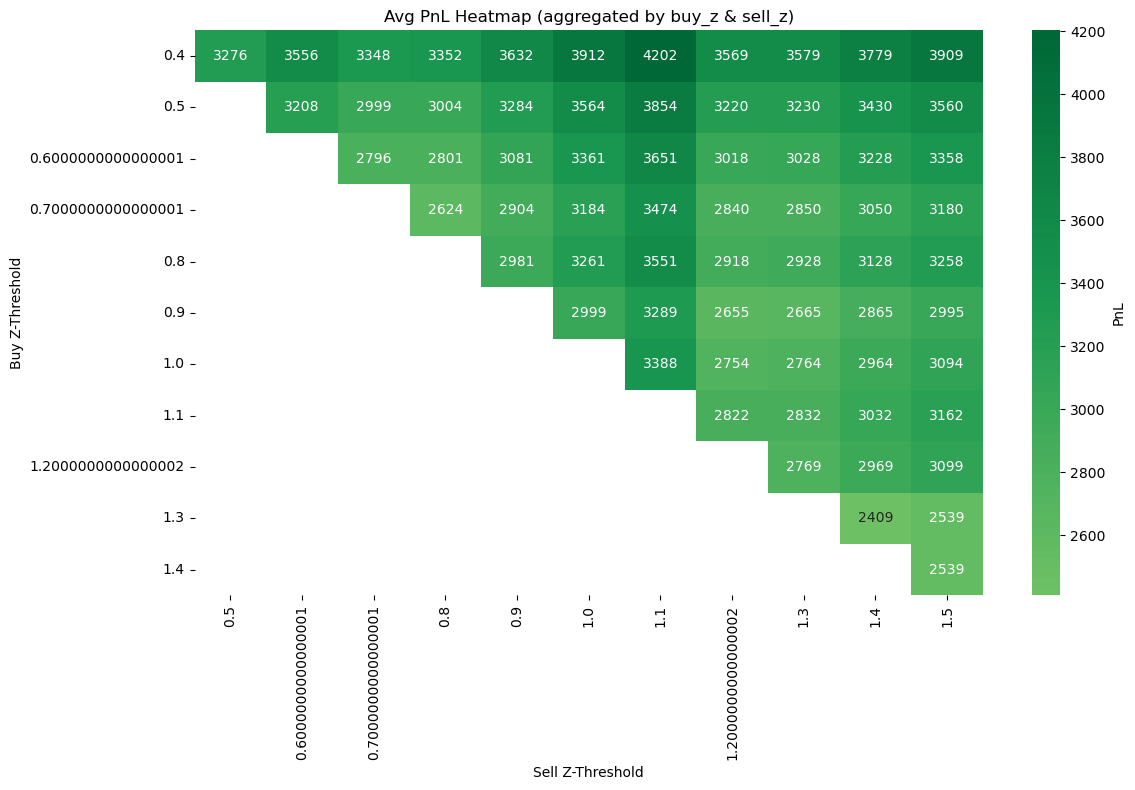

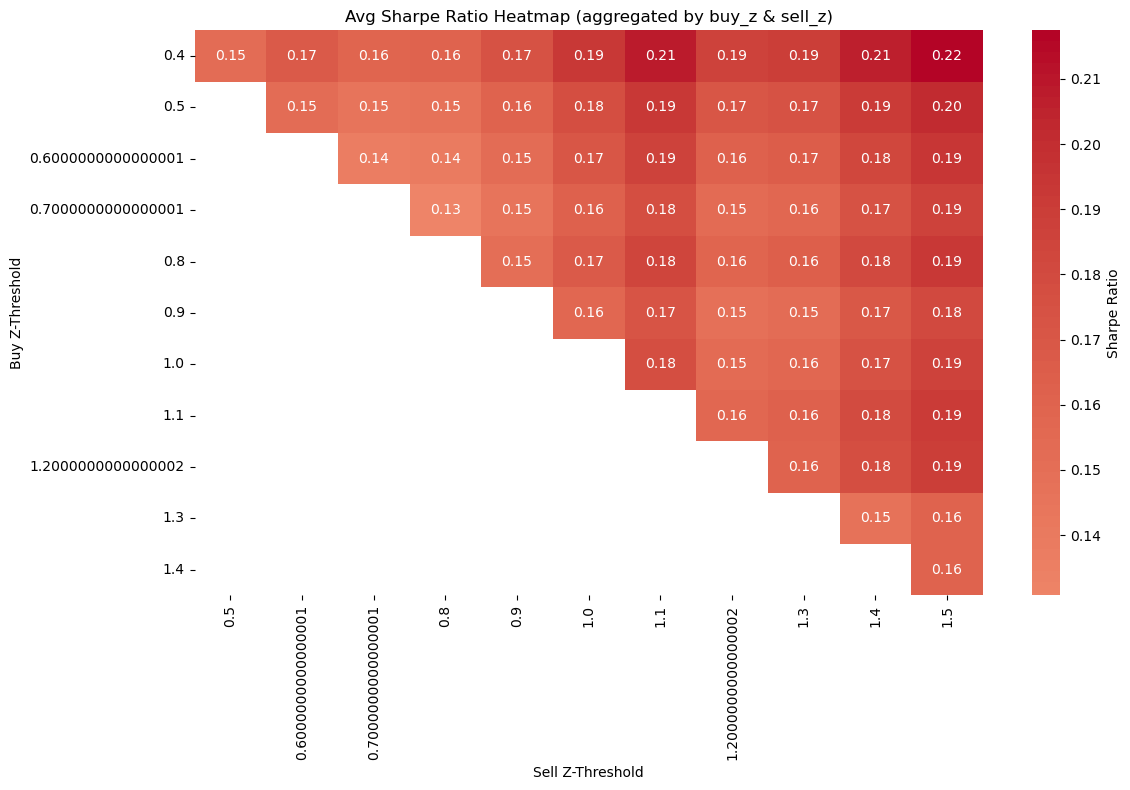

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV
results_df = pd.read_csv("croissants_jams_pair_params.csv")

# Get top 10 configurations for quick reference
top10 = results_df.sort_values("pnl", ascending=False).head(10)


# Average over duplicates
agg_df = results_df.groupby(["buy_z", "sell_z"], as_index=False).agg({
    "pnl": "mean",
    "sharpe": "mean"
})

# Pivot cleaned data
pivot_pnl = agg_df.pivot(index="buy_z", columns="sell_z", values="pnl")
pivot_sharpe = agg_df.pivot(index="buy_z", columns="sell_z", values="sharpe")

# Plot updated heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_pnl, annot=True, fmt=".0f", cmap="RdYlGn", center=0, cbar_kws={'label': 'PnL'})
plt.title("Avg PnL Heatmap (aggregated by buy_z & sell_z)")
plt.xlabel("Sell Z-Threshold")
plt.ylabel("Buy Z-Threshold")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_sharpe, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={'label': 'Sharpe Ratio'})
plt.title("Avg Sharpe Ratio Heatmap (aggregated by buy_z & sell_z)")
plt.xlabel("Sell Z-Threshold")
plt.ylabel("Buy Z-Threshold")
plt.tight_layout()
plt.show()


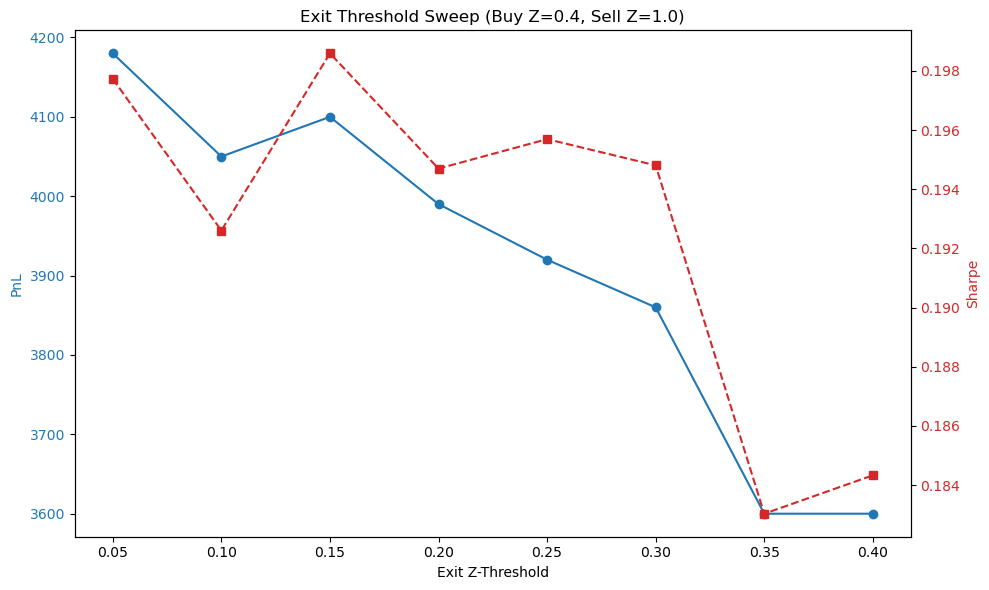

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results assuming you ran a grid and saved results like:
# columns: ["buy_z", "sell_z", "exit_z", "pnl", "sharpe"]
df = pd.read_csv("croissants_jams_pair_params.csv")

# Filter by optimal buy/sell Z
best_buy = 0.4
best_sell = 1.0
filtered = df[(df["buy_z"] == best_buy) & (df["sell_z"] == best_sell)]

# Sort by exit_z
filtered = filtered.sort_values("exit_z")

# Plot PnL and Sharpe vs exit_z
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Exit Z-Threshold")
ax1.set_ylabel("PnL", color="tab:blue")
ax1.plot(filtered["exit_z"], filtered["pnl"], marker="o", color="tab:blue", label="PnL")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Sharpe", color="tab:red")
ax2.plot(filtered["exit_z"], filtered["sharpe"], marker="s", linestyle="--", color="tab:red", label="Sharpe")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title(f"Exit Threshold Sweep (Buy Z={best_buy}, Sell Z={best_sell})")
fig.tight_layout()
plt.show()


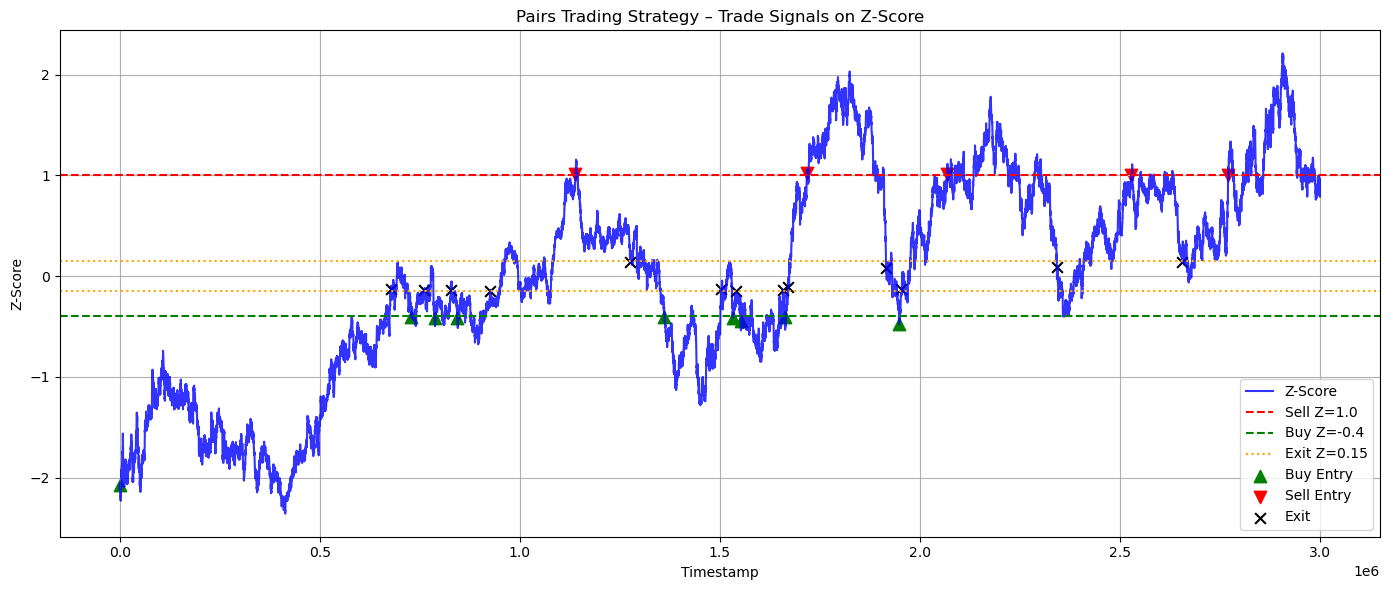

In [10]:
import matplotlib.pyplot as plt

def plot_pair_trades(pivot_df, buy_z=0.4, sell_z=1.0, exit_z=0.15, order_size=20):
    position1 = 0
    position2 = 0
    cash = 0
    z_scores = pivot_df["z_score"].values
    timestamps = pivot_df.index.values

    pnl_series = []
    buy_signals = []
    sell_signals = []
    exit_signals = []

    for i, (ts, row) in enumerate(pivot_df.iterrows()):
        z = row["z_score"]
        p1 = row["CROISSANTS"]
        p2 = row["JAMS"]

        # Entry
        if position1 == 0 and position2 == 0:
            if z > sell_z:
                position1 = -order_size
                position2 = order_size
                cash += order_size * p1 - order_size * p2
                sell_signals.append((ts, z))
            elif z < -buy_z:
                position1 = order_size
                position2 = -order_size
                cash -= order_size * p1 - order_size * p2
                buy_signals.append((ts, z))

        # Exit
        elif abs(z) < exit_z:
            cash += position1 * p1 + position2 * p2
            exit_signals.append((ts, z))
            position1 = 0
            position2 = 0

        pnl = cash + position1 * p1 + position2 * p2
        pnl_series.append(pnl)

    # Unzip signals
    buy_ts, buy_zs = zip(*buy_signals) if buy_signals else ([], [])
    sell_ts, sell_zs = zip(*sell_signals) if sell_signals else ([], [])
    exit_ts, exit_zs = zip(*exit_signals) if exit_signals else ([], [])

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, z_scores, label="Z-Score", color="blue", alpha=0.8)
    plt.axhline(sell_z, linestyle="--", color="red", label=f"Sell Z={sell_z}")
    plt.axhline(-buy_z, linestyle="--", color="green", label=f"Buy Z=-{buy_z}")
    plt.axhline(exit_z, linestyle=":", color="orange", label=f"Exit Z={exit_z}")
    plt.axhline(-exit_z, linestyle=":", color="orange")

    # Plot trades
    plt.scatter(buy_ts, buy_zs, color="green", marker="^", s=80, label="Buy Entry")
    plt.scatter(sell_ts, sell_zs, color="red", marker="v", s=80, label="Sell Entry")
    plt.scatter(exit_ts, exit_zs, color="black", marker="x", s=60, label="Exit")

    plt.title("Pairs Trading Strategy – Trade Signals on Z-Score")
    plt.xlabel("Timestamp")
    plt.ylabel("Z-Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pair_trades(pivot, buy_z=0.4, sell_z=1.0, exit_z=0.15)


# .4 was best but i went with .6 since .4 felt overfit